##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Model tuning with Python

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemini-api/docs/model-tuning/python"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
  </td>
    <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemini-api/docs/model-tuning/python.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemini-api/docs/model-tuning/python.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this notebook, you'll learn how to get started with the tuning service using the Python client library for the Gemini API. Here, you'll learn how to tune the text model behind the Gemini API's text generation service.

## Setup

### Install the client library

In [1]:
!pip install -q google-generativeai

### Import libraries

In [2]:
import google.generativeai as genai

In [3]:
from google.colab import userdata
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

You can check you existing tuned models with the `genai.list_tuned_model` method.

In [4]:
for i, m in zip(range(5), genai.list_tuned_models()):
  print(m.name)

tunedModels/generate-ner-1
tunedModels/generate-relationalner-3
tunedModels/generate-relationalner-4
tunedModels/generate-relationalner-5


## Create tuned model

To create a tuned model, you need to pass your dataset to the model in the `genai.create_tuned_model` method. You can do this be directly defining the input and output values in the call or importing from a file into a dataframe to pass to the method.

For this example, you will tune a model to generate the next number in the sequence. For example, if the input is `1`, the model should output `2`. If the input is `one hundred`, the output should be `one hundred one`.

In [5]:
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods and
    "flash" in m.name][0]
base_model

Model(name='models/gemini-1.5-flash-001-tuning',
      base_model_id='',
      version='001',
      display_name='Gemini 1.5 Flash 001 Tuning',
      description=('Version of Gemini 1.5 Flash that supports tuning, our fast and versatile '
                   'multimodal model for scaling across diverse tasks, released in May of 2024.'),
      input_token_limit=16384,
      output_token_limit=8192,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=1.0,
      max_temperature=2.0,
      top_p=0.95,
      top_k=64)

In [6]:
##read in csv file and parse text_input and output pairs to feed into the "training data" object
#Training data has a format where each input_output pair is a dict with key text_input and key output, values are the actual ones
#Need to essentially have n=45 dictionaries
import pandas as pd
import ast

training_data_ner = []

train_df = pd.read_csv("train_ner_finetune.csv")

for i in range(len(train_df)):
  drugs_str = train_df['drugs'].iloc[i]
  note = train_df['meds_section'].iloc[i]
  temp_dict = {
             'text_input': note,
             'output': drugs_str,
        }
  training_data_ner.append(temp_dict)







FileNotFoundError: [Errno 2] No such file or directory: 'train_ner_finetune.csv'

In [ ]:
name = 'generate-ner-1'
operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    source_model=base_model.name,
    training_data=training_data_ner,
    id = name,
    epoch_count = 100,
    batch_size=4,
    learning_rate=0.001,
)

Your tuned model is immediately added to the list of tuned models, but its status is set to "creating" while the model is tuned.

In [4]:
model = genai.get_tuned_model(f'tunedModels/generate-relationalner-3')

model

TunedModel(name='tunedModels/generate-relationalner-3',
           source_model='tunedModels/generate-ner-1',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='',
           description='',
           temperature=1.0,
           top_p=0.95,
           top_k=64,
           state=<State.ACTIVE: 2>,
           create_time=datetime.datetime(2025, 4, 29, 1, 57, 39, 489215, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2025, 4, 29, 2, 39, 27, 124675, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=datetime.datetime(2025, 4, 29, 1, 57, 39, 627380, tzinfo=datetime.timezone.utc),
                                  complete_time=datetime.datetime(2025, 4, 29, 2, 39, 27, 124675, tzinfo=datetime.timezone.utc),
                                  snapshots=[...],
                                  hyperparameters=Hyperparameters(epoch_count=100,
                                                                  batc

In [5]:
model.state

<State.ACTIVE: 2>

### Check tuning progress

Use `metadata` to check the state:

In [ ]:
operation.name

'tunedModels/generate-ner-1/operations/nqgn5wbljcxn'

Wait for the training to finish using `operation.result()`, or `operation.wait_bar()`

In [ ]:
import time

for status in operation.wait_bar():
  time.sleep(30)

  0%|          | 0/1025 [00:00<?, ?it/s]

You can cancel your tuning job any time using the `cancel()` method. Uncomment the line below and run the code cell to cancel your job before it finishes.

In [ ]:
# operation.cancel()

Once the tuning is complete, you can view the loss curve from the tuning results. The [loss curve](https://ai.google.dev/gemini-api/docs/model-tuning#recommended_configurations) shows how much the model's predictions deviate from the ideal outputs.

<Axes: xlabel='epoch', ylabel='mean_loss'>

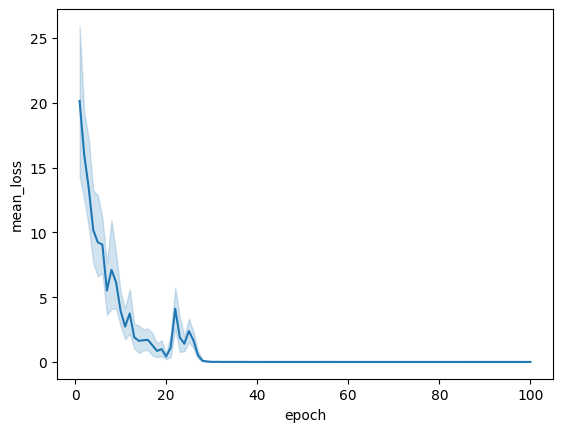

In [ ]:
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')


## Evaluate your model

You can use the `genai.generate_content` method and specify the name of your model to test your model performance.

In [7]:
import pandas as pd
model = genai.GenerativeModel(model_name=f'tunedModels/generate-ner-3')
test_df = pd.read_csv('test_ner_finetune.csv')

In [70]:

result = model.generate_content(test_df['meds_section'].iloc[4], safety_settings=[
        {
            "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
            "threshold": "HIGH",  # Allow 'medium' but block at 'high'
        },
        {
            "category": "HARM_CATEGORY_HATE_SPEECH",
            "threshold": "HIGH",
        },
        {
            "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
            "threshold": "HIGH",
        },
        {
            "category": "HARM_CATEGORY_HARASSMENT",
            "threshold": "HIGH",
        },
    ])

In [71]:
import ast
predicted_drugs = result.text
index = predicted_drugs.find('[')
predicted_drugs = predicted_drugs[index:]

predicted_drugs_list = ast.literal_eval(predicted_drugs)

true_drugs_list = ast.literal_eval(test_df['drugs'].iloc[4])

def proportion_overlap(set1, set2):
    """
    Compute the proportion of elements in set1 that exist in set2 (case insensitive).

    Args:
        set1 (iterable): First set/list of elements.
        set2 (iterable): Second set/list of elements.

    Returns:
        float: Proportion of set1 elements that are found in set2.
    """
    # Normalize everything to strings, lowercase, and strip
    set1 = {str(e).lower().strip() for e in set1}
    set2 = {str(e).lower().strip() for e in set2}

    if len(set1) == 0:
        return 0.0  # Avoid division by zero

    # Find intersection
    intersection = set1 & set2

    # Calculate proportion
    return len(intersection) / len(set1)

print(proportion_overlap(predicted_drugs_list, true_drugs_list))
print(predicted_drugs_list)


0.8888888888888888
['Warfarin', 'Acetaminophen', 'Lisinopril', 'Metoprolol Tartrate', 'Simvastatin', 'Levothyroxine Sodium', 'Torsemide', 'Calcitriol', 'Glargine']


It really seems to have picked up the task despite the limited examples, but "next" is a simple concept, see the [tuning guide](https://ai.google.dev/gemini-api/docs/model-tuning) for more guidance on improving performance.

Now, we have done the NER task and fine-tuning for that. We will use this NER model as our base now and try for relational NER with the tuple format, and a specific prompt to ensure the model tries to capture relational information. Let's give it the whole note and see how it performs fine-tuning wise.

In [24]:
import pandas as pd
training_data_relational_ner = [] #the final array of training data

prompt_begin = """
For each medication, perform relational named entity recognition and extract the following fields from the given clinical note:

- "Drug Name": The name of the drug mentioned.
- "Drug Dosage": The numeric dosage (if explicitly stated); otherwise, "Not mentioned."
- "Unit of Dosage": The unit (e.g., mg, mL) (if stated); otherwise, "Not mentioned."
- "Drug Form": The formulation (e.g., Tablet, Vial) (if stated); otherwise, "Not mentioned."
- "Route": The route of administration (e.g., PO, IV) (if stated); otherwise, "Not mentioned."

**Output format:**
Return a **strict JSON object**, where:
- Keys are drug names.
- Values are **lists of dictionaries**, each with the following keys: `"Drug Dosage"`, `"Unit of Dosage"`, `"Route"`, and `"Drug Form"`.

Do not include any NON extra explanation, formatting, or headers—just the JSON object.

---

**Example 1:**

Note: "Patient prescribed aspirin 81 mg tablet by mouth daily. Also mentioned metformin 500 mg tablet taken orally twice a day."

Expected Output:
```json
{
  "aspirin": [
    {
      "Drug Dosage": "81",
      "Unit of Dosage": "mg",
      "Route": "PO",
      "Drug Form": "Tablet"
    }
  ],
  "metformin": [
    {
      "Drug Dosage": "500",
      "Unit of Dosage": "mg",
      "Route": "PO",
      "Drug Form": "Tablet"
    }
  ]
}
Now, here is the actual note to extract from\n:
"""

train_relational_finetune_df = pd.read_csv("train_relational_finetune.csv")

for i in range(len(train_relational_finetune_df)):
  prompt = train_relational_finetune_df['meds_section'].iloc[i]
  expected_output = train_relational_finetune_df['json_formatted_meds_section_gt'].iloc[i]
  training_data_relational_ner.append(
      {
          'text_input': prompt,
          'output': expected_output
      }
  )

print(training_data_relational_ner[0]['output'])


name = 'generate-relationalner-5'
operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    source_model="tunedModels/generate-ner-1",
    training_data=training_data_relational_ner,
    id = name,
    epoch_count = 100,
    batch_size=4,
    learning_rate=0.001,
    temperature=0.3
)

{
  "Diazepam": [
    {
      "Drug Dosage": "5",
      "Unit of Dosage": "mg",
      "Route": "PO/NG",
      "Drug Form": "TAB"
    }
  ],
  "Acetaminophen": [
    {
      "Drug Dosage": "1000",
      "Unit of Dosage": "mg",
      "Route": "PO/NG",
      "Drug Form": "TAB"
    }
  ],
  "Simvastatin": [
    {
      "Drug Dosage": "10",
      "Unit of Dosage": "mg",
      "Route": "PO/NG",
      "Drug Form": "TAB"
    }
  ],
  "Atenolol": [
    {
      "Drug Dosage": "25",
      "Unit of Dosage": "mg",
      "Route": "PO/NG",
      "Drug Form": "TAB"
    }
  ],
  "Docusate Sodium": [
    {
      "Drug Dosage": "100",
      "Unit of Dosage": "mg",
      "Route": "PO/NG",
      "Drug Form": "CAP"
    }
  ],
  "Gabapentin": [
    {
      "Drug Dosage": "100",
      "Unit of Dosage": "mg",
      "Route": "PO/NG",
      "Drug Form": "CAP"
    }
  ]
}


In [25]:
model = genai.get_tuned_model(f'tunedModels/{name}')
model.state

<State.CREATING: 1>

In [26]:
operation.name

'tunedModels/generate-relationalner-5/operations/ymfwcswo54ql'

In [35]:
import time

for status in operation.wait_bar():
  time.sleep(30)

  0%|          | 0/1025 [00:00<?, ?it/s]

In [36]:
tuned_model = genai.get_tuned_model(f'tunedModels/generate-relationalner-5')
tuned_model.state

<State.ACTIVE: 2>

In [8]:
#Model has been fine-tuned; include methods to compare tuples here
import numpy as np

def jaccard_similarity_case_insensitive(tuple1, tuple2):
    """Compute Jaccard similarity between two tuples of strings, ignoring case."""
    set1 = set(str(x).lower() for x in tuple1)
    set2 = set(str(x).lower() for x in tuple2)
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0.0

def match_and_score_tuples(model_tuples, ground_truth_tuples):
    """
    Matches tuples between model and ground truth using maximum Jaccard similarity,
    and computes the average similarity, number of hallucinations, and misses.
    """
    model_tuples = list(model_tuples)  # Ensure lists
    ground_truth_tuples = list(ground_truth_tuples)

    n_model = len(model_tuples)
    n_gt = len(ground_truth_tuples)

    if n_model == 0 and n_gt == 0:
        return 1.0, 0, 0  # Perfect match if nothing predicted and nothing to find

    # Build similarity matrix
    sim_matrix = np.zeros((n_model, n_gt))
    for i, model_tuple in enumerate(model_tuples):
        for j, gt_tuple in enumerate(ground_truth_tuples):
            sim_matrix[i, j] = jaccard_similarity_case_insensitive(model_tuple, gt_tuple)

    matched_model = set()
    matched_gt = set()
    matches = []

    while True:
        # Find the max similarity pair
        max_sim = -1
        max_i, max_j = -1, -1
        for i in range(n_model):
            if i in matched_model:
                continue
            for j in range(n_gt):
                if j in matched_gt:
                    continue
                if sim_matrix[i, j] > max_sim:
                    max_sim = sim_matrix[i, j]
                    max_i, max_j = i, j

        if max_sim <= 0:
            break  # No more good matches

        matched_model.add(max_i)
        matched_gt.add(max_j)
        matches.append(max_sim)

    num_hallucinations = n_model - len(matched_model)
    num_misses = n_gt - len(matched_gt)
    average_similarity = np.mean(matches) if matches else 0.0

    return average_similarity, num_hallucinations, num_misses

In [8]:
model = genai.GenerativeModel(model_name=f'tunedModels/generate-relationalner-3')
test_relational_df = pd.read_csv("test_relational_finetune.csv")

In [9]:
result = model.generate_content(test_relational_df['meds_section'].iloc[3], safety_settings=[
        {
            "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
            "threshold": "HIGH",  # Allow 'medium' but block at 'high'
        },
        {
            "category": "HARM_CATEGORY_HATE_SPEECH",
            "threshold": "HIGH",
        },
        {
            "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
            "threshold": "HIGH",
        },
        {
            "category": "HARM_CATEGORY_HARASSMENT",
            "threshold": "HIGH",
        },
    ])

In [10]:
json_predictions = []
for i in range(len(test_relational_df)):
  result = model.generate_content(test_relational_df['meds_section'].iloc[i], safety_settings=[
        {
            "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
            "threshold": "HIGH",  # Allow 'medium' but block at 'high'
        },
        {
            "category": "HARM_CATEGORY_HATE_SPEECH",
            "threshold": "HIGH",
        },
        {
            "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
            "threshold": "HIGH",
        },
        {
            "category": "HARM_CATEGORY_HARASSMENT",
            "threshold": "HIGH",
        },
    ])
  json_predictions.append(result.text)


In [22]:
print(json_predictions[1])

#test_relational_df["json_predictions"] = json_predictions

#test_relational_df.to_csv("test_with_outputs_relational.csv")

## Discharge Summary:

**Patient:**  {Patient Name}
**Date of Birth:**  {Patient Date of Birth}
**Admitting Diagnosis:**  Coronary Artery Disease
**Reason for Admission:**  s/p Coronary artery Bypass Grafting/Aortic Valve Replacement
**Past History:**  Hypertension, Hyperlipidemia, Chronic atrial fibrillation (on ASA, no coumadin), Diastolic CHF (EF 60%), h/o cervical fx, s/p C3-C5 laminectomy, resulting in mild atony of bladder and neurogenic bladder, indwelling Foley x{Duration}, GERD, BPH, multiple urinary tract infections, CKD stage I-II, skin cancer resection of left shoulder {Duration} years ago, draining cellulitis of both legs x{Duration} weeks, h/o MRSA.
**Allergies:**  NKA
**Medications:**
- Atorvastatin 80 mg once a day PO/NG
- Quetiapine 25 mg 3 times a day PO/NG
- Insulin Regular Human 100 unit/mL sliding scale SC
- Metoprolol Tartrate 50 mg 2 times a day PO/NG
- Potassium Chloride 10 mEq once a day PO/NG
- Captopril 25 mg 2 times a day PO/NG
- Docusate Sodium 100 mg once 

<Axes: xlabel='epoch', ylabel='mean_loss'>

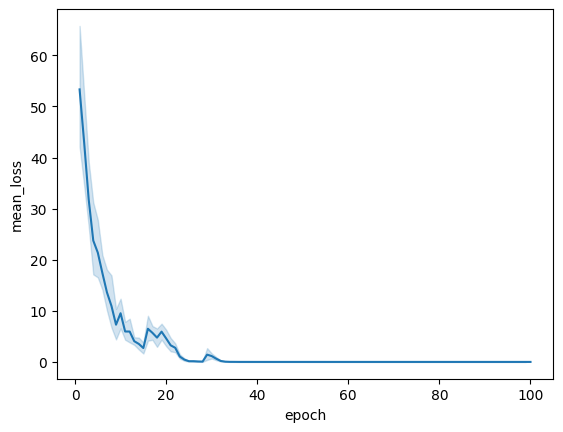

In [ ]:
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')

Here, we make a new model but the training data has been artifically injected with not mentioned values. This is to see if our test output will now contain more not mentioned values than before.

In [44]:
import pandas as pd
train_relational_null_df = pd.read_csv("train_relational_null_injected.csv")
training_data_null_injected = []

for i in range(len(train_relational_null_df)):
  prompt = train_relational_null_df['meds_section'].iloc[i]
  expected_output = train_relational_null_df['null_injected_gt'].iloc[i]
  training_data_null_injected.append(
      {
          'text_input': prompt,
          'output': expected_output
      }
  )


name = 'generate-nullinjected-1'
operation = genai.create_tuned_model(
    # You can use a tuned model here too. Set `source_model="tunedModels/..."`
    source_model="tunedModels/generate-ner-1", ##the generate-ner-1 model is our fine-tuned traditional NER model
    training_data=training_data_null_injected,
    id = name,
    epoch_count = 100,
    batch_size=4,
    learning_rate=0.001,
)

In [45]:
print(name)
model = genai.get_tuned_model(f'tunedModels/{name}')
print(model.state)
print(operation.name)

import time

for status in operation.wait_bar():
  time.sleep(30)


generate-nullinjected-1
1
tunedModels/generate-nullinjected-1/operations/3eo9h1y4kgzh


  0%|          | 0/1025 [00:00<?, ?it/s]

In [55]:
#Now let's test it on the validation set
model = genai.GenerativeModel(model_name=f'tunedModels/generate-nullinjected-1')
test_null_injected_df = pd.read_csv("test_relational_finetune.csv")

result = model.generate_content(test_null_injected_df['meds_section'].iloc[1], safety_settings=[
        {
            "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
            "threshold": "HIGH",  # Allow 'medium' but block at 'high'
        },
        {
            "category": "HARM_CATEGORY_HATE_SPEECH",
            "threshold": "HIGH",
        },
        {
            "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
            "threshold": "HIGH",
        },
        {
            "category": "HARM_CATEGORY_HARASSMENT",
            "threshold": "HIGH",
        },
    ])

print(result.text)

## Drug Dosage and Route:

**1. Aspirin 81mg Tablet, Delayed Release (E.C.)**
* Dosage: 325mg
* Route: Not Mentioned
* Unit of Dosage: mg

**2. Ranitidine HCl 150mg Tablet**
* Dosage: 150mg
* Route: PO
* Unit of Dosage: mg

**3. Docusate Sodium 100mg Capsule**
* Dosage: 100mg
* Route: PO
* Unit of Dosage: mg

**4. Acetaminophen 325mg Tablet**
* Dosage: 650mg
* Route: PO
* Unit of Dosage: mg

**5. Bisacodyl 10mg Suppository**
* Dosage: 10mg
* Route: PR
* Unit of Dosage: mg

**6. Magnesium Hydroxide 400mg/5mL Suspension**
* Dosage: 15mL
* Route: PO
* Unit of Dosage: mL

**7. Atorvastatin 80mg Tablet**
* Dosage: 80mg
* Route: Not Mentioned
* Unit of Dosage: mg

**8. Heparin (Porcine) 5,000 unit/mL Solution**
* Dosage: 5,000
* Route: SC
* Unit of Dosage: UNIT

**9. Finasteride 5mg Tablet**
* Dosage: 5mg
* Route: Not Mentioned
* Unit of Dosage: mg

**10. Quetiapine 25mg Tablet**
* Dosage: 25mg
* Route: PO
* Unit of Dosage: mg

**11. Captopril 25mg Tablet**
* Dosage: 50mg
* Route: PO
* Unit 

In [54]:
import json
def json_to_tuple(json_string):

    data = json.loads(json_string)

    fields = ["Drug Dosage", "Unit of Dosage", "Route", "Drug Form"]

    tuple_form = {
        drug: [tuple(mention[field] for field in fields) for mention in mentions]
        for drug, mentions in data.items()
    }
    return tuple_form

## Update the description

You can update the description of your tuned model any time using the `genai.update_tuned_model` method.

In [ ]:
genai.update_tuned_model(f'tunedModels/{name}', {"description":"This is my model."});

In [ ]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model.description

'This is my model.'

## Delete the model

You can clean up your tuned model list by deleting models you no longer need. Use the `genai.delete_tuned_model` method to delete a model. If you canceled any tuning jobs, you may want to delete those as their performance may be unpredictable.

In [43]:
genai.delete_tuned_model(f'tunedModels/generate-nullinjected-1')

The model no longer exists:

In [ ]:
try:
  m = genai.get_tuned_model(f'tunedModels/{name}')
  print(m)
except Exception as e:
  print(f"{type(e)}: {e}")

<class 'google.api_core.exceptions.NotFound'>: 404 GET https://generativelanguage.googleapis.com/v1beta/tunedModels/generate-num-588?%24alt=json%3Benum-encoding%3Dint: Tuned model tunedModels/generate-num-588 does not exist.
